<a href="https://colab.research.google.com/github/GabrielaGroenenewegenVanDerWeijden/DS_Ass2/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
!pip install tensorflow
!pip install tensorflow==2.18.0
!pip install tensorflow-text==2.18.1
!pip install tf-keras==2.18.0
!pip install jax==0.5.2
!pip install ml-dtypes==0.4.0
!pip install protobuf==5.26.1
!pip install grpcio-status==1.71.0
!pip install google-cloud-pubsub==2.29.0
!pip install xplique==0.3.0

In [15]:
# Uninstall potentially conflicting versions
!pip uninstall -y tensorflow tensorflow-text tf-keras jax ml-dtypes protobuf grpcio-status google-cloud-pubsub

# Reinstall tensorflow
!pip install tensorflow==2.18.0

Found existing installation: tensorflow-text 2.18.1
Uninstalling tensorflow-text-2.18.1:
  Successfully uninstalled tensorflow-text-2.18.1
Found existing installation: tf_keras 2.18.0
Uninstalling tf_keras-2.18.0:
  Successfully uninstalled tf_keras-2.18.0
Found existing installation: jax 0.5.2
Uninstalling jax-0.5.2:
  Successfully uninstalled jax-0.5.2
Found existing installation: ml_dtypes 0.5.1
Uninstalling ml_dtypes-0.5.1:
  Successfully uninstalled ml_dtypes-0.5.1
Found existing installation: protobuf 5.26.1
Uninstalling protobuf-5.26.1:
  Successfully uninstalled protobuf-5.26.1
Found existing installation: grpcio-status 1.71.0
Uninstalling grpcio-status-1.71.0:
  Successfully uninstalled grpcio-status-1.71.0
Found existing installation: google-cloud-pubsub 2.29.0
Uninstalling google-cloud-pubsub-2.29.0:
  Successfully uninstalled google-cloud-pubsub-2.29.0
  Using cached tensorflow-2.18.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cache

In [13]:
!pip uninstall tensorflow
!pip install tensorflow==2.18.0

  Using cached tensorflow-2.18.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
Using cached tensorflow-2.18.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (615.4 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires jax>=0.1.72, which is not installed.
dopamine-rl 4.1.2 requires tf-keras>=2.18.0, which is not installed.


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import cv2
import os
import optuna
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.losses import BinaryCrossentropy
import xplique
from xplique.plots import plot_attributions
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow.keras.applications as app
from IPython.display import Image, display


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [3]:
for dirname, _, filenames in os.walk('/kaggle/input/chest-xray-pneumonia'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person629_bacteria_2509.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person952_bacteria_2877.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1315_virus_2270.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1392_bacteria_3538.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person475_bacteria_2025.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1288_bacteria_3251.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1005_virus_1688.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person442_virus_900.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person755_bacteria_2659.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person655_bacteria_2547.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray

In [4]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) / 255.0  # Normalize

                data.append((resized_arr, class_num))
            except Exception as e:
                print(f"Error processing {img}: {e}")


    return np.array(data, dtype=object)

### Loading the data set

In [5]:
train = get_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/train/')
test = get_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/test/')
val = get_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/val/')

### Data visualization & Preprocessing.

<Axes: xlabel='Condition', ylabel='count'>

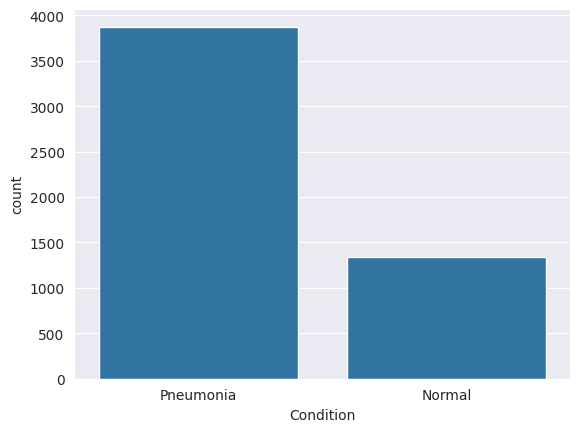

In [7]:
l = []
for i in train:
    if (i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")

sns.set_style('darkgrid')

#Converding the list into a dataframe so that countplot can accept it.
df = pd.DataFrame({"Condition": l})


sns.countplot(x="Condition", data=df)

### Previewing the images of both the classes.

In [ ]:
plt.figure(figsize= (5,5))
plt.imshow(train[0][0], cmap="gray")
plt.title(labels[train[0][1]])


plt.figure(figsize= (5,5))
plt.imshow(train[-1][0], cmap="gray")
plt.title(labels[train[-1][1]])

### We perform a grayscale normalization to reduce the effect of illumination's differences. Moreover, the CNN converges faster on [0..1] data than on [0...255]

In [6]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Make them into arrays
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
x_val = np.array(x_val)
y_val = np.array(y_val)

In [7]:
# try to resize data to mauybe get better output.
x_train = x_train.reshape(-1, img_size, img_size, 1)


x_test = x_test.reshape(-1, img_size, img_size, 1)


x_val = x_val.reshape(-1, img_size, img_size, 1)


### Data Augmentation

In [8]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


In [9]:
datagen.fit(x_train)

### Training the Model

In [ ]:
# model = Sequential()
# model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(Dropout(0.1))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Flatten())
# model.add(Dense(units = 128 , activation = 'relu'))
# model.add(Dropout(0.2))
# model.add(Dense(units = 1 , activation = 'sigmoid'))
# model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
# model.summary()

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

# DIT IS AL GERUND, DOE HET NIET OPNIEUW TENZIJ JE KOSTBARE TIJD WILT VERSPILLN

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=12, validation_data= datagen.flow(x_val, y_val), callbacks =[learning_rate_reduction])

In [ ]:
# print("Loss of the model is - " , model.evaluate(x_test, y_test)[0])
# print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

### Analysis after model training

In [ ]:
# epochs = [i for i in range(12)]
# fig , ax = plt.subplots(1,2)
# train_acc = history.history['accuracy']
# train_loss = history.history['loss']
# val_acc = history.history['val_accuracy']
# val_loss = history.history['val_loss']
# fig.set_size_inches(20,10)

# ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
# ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
# ax[0].set_title('Training & Validation Accuracy')
# ax[0].legend()
# ax[0].set_xlabel("Epochs")
# ax[0].set_ylabel("Accuracy")

# ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
# ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
# ax[1].set_title('Testing Accuracy & Loss')
# ax[1].legend()
# ax[1].set_xlabel("Epochs")
# ax[1].set_ylabel("Training & Validation Loss")
# plt.show()

In [ ]:
# # predictions = model.predict_classes(x_test)
# predictions = (model.predict(x_test) > 0.5).astype("int32").flatten()
# predictions = predictions.reshape(1,-1)[0]
# predictions[:46]

In [ ]:
# print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

In [ ]:
# cm = confusion_matrix(y_test,predictions)
# cm

### Deze stuk hoeft aleen als er sns.heatmap gebruiken, maar dat zorgde dat niet alle cijfers zichtbaar waren dus heb CunfusionMatrixDisplay gebruikt.

In [ ]:
# cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

In [ ]:
# plt.figure(figsize = (10,10))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# disp.plot(cmap='Purples', colorbar=True)
# plt.grid(False)


In [ ]:
# correct = np.nonzero(predictions == y_test)[0]
# incorrect = np.nonzero(predictions != y_test)[0]

### Some correctly predicted classes

In [ ]:
# i = 0
# for c in correct[:6]:
#     plt.subplot(3,2,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
#     plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
#     # plt.tight_layout()
#     i += 1

### Some incorrectly predicted classes

In [ ]:
# i = 0
# for c in incorrect[:6]:
#     plt.subplot(3,2,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
#     plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
#     # plt.tight_layout()
#     i += 1

##Going to Part 2 of the assignment trying to Hyper-Parameter Optimization / Bayesian Optimization


In [ ]:
# def objective(trial):
#     # --- Hyperparameter suggestions ---
#     filters1 = trial.suggest_categorical('filters1', [32, 64])
#     dropout1 = trial.suggest_categorical('dropout1', [0.1, 0.15])
#     dropout2 = trial.suggest_categorical('dropout2', [0.15, 0.25])
#     kernel_size = trial.suggest_categorical('kernel_size', [3, 5])
#     learning_factor = trial.suggest_categorical('learning_factor', [0.1, 0.25, 0.5, 0.75, 0.9])

#     if filters1 == 32:
#         dense_units = trial.suggest_int('dense_units', 64, 128)
#     else:
#         dense_units = trial.suggest_int('dense_units', 128, 256)

#     # --- Build the model ---
#     model = Sequential()
#     model.add(Conv2D(filters1, (kernel_size, kernel_size), strides = 1,activation='relu', padding='same', input_shape=(150, 150, 1)))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D((2, 2), strides = 2, padding='same'))

#     model.add(Conv2D(filters1, (kernel_size, kernel_size), strides = 1, activation='relu', padding='same'))
#     model.add(Dropout(dropout1))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D((2, 2), strides =2, padding='same'))

#     model.add(Conv2D(filters1 * 2, (kernel_size, kernel_size), strides = 1, activation='relu', padding='same'))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D((2, 2), strides = 2, padding='same'))

#     model.add(Conv2D(filters1 * 2, (kernel_size, kernel_size), strides = 1, activation='relu', padding='same'))
#     model.add(Dropout(dropout1))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D((2, 2), strides =2, padding='same'))

#     model.add(Conv2D(filters1 * 4, (kernel_size, kernel_size), strides =1, activation='relu', padding='same'))
#     model.add(Dropout(dropout2))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D((2, 2), strides = 2, padding='same'))

#     model.add(Flatten())
#     model.add(Dense(dense_units, activation='relu'))
#     model.add(Dropout(dropout2))
#     model.add(Dense(1, activation='sigmoid'))

#     # --- Compile ---
#     model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])

#     # --- Callbacks ---
#     callbacks = [
#         EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
#         ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=learning_factor, min_lr=1e-6)
#     ]

#     # --- Train ---
#     history = model.fit(
#         datagen.flow(x_train, y_train, batch_size=32),
#         epochs=12,
#         validation_data=datagen.flow(x_val, y_val),
#         callbacks=callbacks
#     )

#     # Return validation accuracy of last epoch
#     return history.history['val_accuracy'][-1]


In [ ]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=20)

In [10]:
model10 = Sequential()
model10.add(Conv2D(32 , (5,5) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model10.add(BatchNormalization())
model10.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model10.add(Conv2D(32 , (5,5) , strides = 1 , padding = 'same' , activation = 'relu'))
model10.add(Dropout(0.1))
model10.add(BatchNormalization())
model10.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model10.add(Conv2D(64 , (5,5) , strides = 1 , padding = 'same' , activation = 'relu'))
model10.add(BatchNormalization())
model10.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model10.add(Conv2D(64 , (5,5) , strides = 1 , padding = 'same' , activation = 'relu'))
model10.add(Dropout(0.1))
model10.add(BatchNormalization())
model10.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model10.add(Conv2D(128 , (5,5) , strides = 1 , padding = 'same' , activation = 'relu'))
model10.add(Dropout(0.15))
model10.add(BatchNormalization())
model10.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model10.add(Flatten())
model10.add(Dense(units = 70 , activation = 'relu'))
model10.add(Dropout(0.15))
model10.add(Dense(units = 1 , activation = 'sigmoid'))
model10.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model10.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 38, 38, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 38, 38, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 38, 38, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 19, 19, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 19, 19, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 10, 10, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3200)                │              

 Total params: 610,541 (2.33 MB)

 Trainable params: 609,901 (2.33 MB)

 Non-trainable params: 640 (2.50 KB)

In [11]:
learning_rate_reduction10 = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [12]:
history = model10.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=40, validation_data= datagen.flow(x_val, y_val), callbacks =[learning_rate_reduction10])

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-12-2737730e0a1b>", line 1, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_3777]

In [ ]:
print("Loss of the model is - " , model10.evaluate(x_test, y_test)[0])
print("Accuracy of the model is - " , model10.evaluate(x_test,y_test)[1]*100 , "%")

In [ ]:
predictions = (model10.predict(x_test) > 0.5).astype("int32").flatten()
predictions = predictions.reshape(1,-1)[0]
predictions[:46]

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

In [ ]:
cm = confusion_matrix(y_test,predictions)

In [ ]:
plt.figure(figsize = (10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Purples', colorbar=True)
plt.grid(False)


In [ ]:
model10.save("91_Percent.keras")

##Part 3: XAI


In [ ]:
!pip uninstall -y tensorflow tensorflow-text tf-keras jax ml-dtypes protobuf grpcio-status google-cloud-pubsub


### Making the GradCAM algorithm from scratch


In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)
    max_val = tf.reduce_max(heatmap)
    if max_val == 0:
        heatmap = tf.zeros_like(heatmap)
    else:
        heatmap /= max_val

    return heatmap.numpy()


In [ ]:
# Get last convolutional layer
last_conv_layer = [layer for layer in model10.layers if isinstance(layer, tf.keras.layers.Conv2D)][-1]

print(last_conv_layer.name)
# Instead of using xception.decode_predictions, which is designed for ImageNet (1000 classes)
# We'll interpret the raw predictions from our binary classifier
def decode_binary_predictions(preds):
    """Decodes predictions for a binary classification model."""
    predicted_classes = (preds > 0.5).astype(int)  # Threshold at 0.5
    class_labels = ['Pneumonia', 'Normal']  # Assuming labels are in this order
    return [class_labels[pred] for pred in predicted_classes.flatten()]

# Prepare images
X = np.concatenate((x_train, x_val, x_test), axis = 0)
Y = np.concatenate((y_train, y_val, y_test), axis = 0)

X = X.reshape(-1, 150, 150, 1)


# Our model
ours = model10

# Remove last layer's softmax (if it was applied)
# This might be unnecessary depending on your model definition
ours.layers[-1].activation = None

# Print what the top predicted class is using the custom decoding function
preds = ours.predict(X)
predicted_labels = decode_binary_predictions(preds)
print("Predicted:", predicted_labels[:5])  # Print first 5 predictions for illustration


heatmaps = []
for i in range(len(X)):
    img = np.expand_dims(X[i], axis=0)  # (1, 150, 150, 1)
    heatmap = make_gradcam_heatmap(img, ours, last_conv_layer.name)
    heatmaps.append(heatmap)

heatmap = np.array(heatmaps)  # Combine heatmaps from all batches


In [ ]:

for i in range(10):  # Adjust how many samples you want to visualize
    heatmap = heatmaps[i]
    input_img = X[i].squeeze()  # Shape: (150, 150), normalized (0–1)

    # Resize heatmap to input size
    heatmap_resized = cv2.resize(heatmap, (150, 150))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

    # Convert grayscale image to RGB
    input_rgb = cv2.cvtColor(np.uint8(input_img * 255), cv2.COLOR_GRAY2RGB)

    # Overlay heatmap
    overlay = cv2.addWeighted(input_rgb, 0.6, heatmap_color, 0.3, 0)

    # Plot original + overlay
    plt.figure(figsize=(6, 3))
    plt.suptitle(f"Prediction: {predicted_labels[i]}")

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(input_rgb)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM Overlay")
    plt.imshow(overlay)
    plt.axis('off')

    plt.tight_layout()
    plt.show()